#Подключаем библиотеки и загружаем данные

In [1]:
!pip install catboost

     |████████████████████████████████| 64.8MB 54kB/s 


In [2]:
from sklearn import ensemble, model_selection, datasets, metrics, tree, linear_model, preprocessing 
from sklearn.neural_network import MLPRegressor

from catboost import CatBoostRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import lightgbm as lgb

import xgboost as xgb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Данные по заражениям

In [3]:
!git clone https://github.com/CSSEGISandData/COVID-19 -b web-data COVID-19-new

Cloning into 'COVID-19-new'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 22646 (delta 5), reused 10 (delta 5), pack-reused 22632
Receiving objects: 100% (22646/22646), 98.65 MiB | 31.69 MiB/s, done.
Resolving deltas: 100% (12274/12274), done.


In [4]:
!git clone https://github.com/CSSEGISandData/COVID-19.git


Cloning into 'COVID-19'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 22646 (delta 5), reused 10 (delta 5), pack-reused 22632
Receiving objects: 100% (22646/22646), 98.65 MiB | 30.94 MiB/s, done.
Resolving deltas: 100% (12274/12274), done.


In [5]:
!git clone https://github.com/grwlf/COVID-19_plus_Russia.git

Cloning into 'COVID-19_plus_Russia'...
remote: Enumerating objects: 17561, done.
remote: Total 17561 (delta 0), reused 0 (delta 0), pack-reused 17561
Receiving objects: 100% (17561/17561), 83.49 MiB | 31.13 MiB/s, done.
Resolving deltas: 100% (8922/8922), done.


## Данные про страны

In [6]:
!git clone https://github.com/vlomme/sberbank-covid19-forecast-2020.git

Cloning into 'sberbank-covid19-forecast-2020'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 238 (delta 28), reused 0 (delta 0), pack-reused 193
Receiving objects: 100% (238/238), 7.53 MiB | 10.61 MiB/s, done.
Resolving deltas: 100% (122/122), done.


## Данные по карантинам

In [7]:
!git clone https://github.com/tyz910/sberbank-covid19.git

Cloning into 'sberbank-covid19'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 160 (delta 73), reused 143 (delta 56), pack-reused 0
Receiving objects: 100% (160/160), 1.17 MiB | 2.72 MiB/s, done.
Resolving deltas: 100% (73/73), done.


## Загружаем данные

In [0]:
today = pd.to_datetime('today').strftime("%Y-%m-%d")
#Загрузить список стран и удалить лишние атрибуты 
countries = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/countries.csv")
countries.drop(['iso_alpha2','iso_numeric','official_name','name'], axis='columns',inplace=True)

#Загрузить список регионов
regions = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/russia_regions.csv")
regions = regions[["iso_code","csse_province_state","csse_province_state2","population","population_urban"]]
regions.population_urban = regions.population_urban/regions.population
regions.rename(columns={"iso_code": "iso_alpha3","csse_province_state":"ccse_name","csse_province_state2":"ccse_name2","population_urban":"urban_pop_rate"},inplace=True)

regions_info = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/regions-info.csv", decimal=",")
regions_info = regions_info[["Region_eng","Density_pop_sqkm","Area"]]
regions_info.rename(columns={"Region_eng": "ccse_name2","Area": "land_area","Density_pop_sqkm": "density"},inplace=True)
regions= regions.merge(regions_info, how = 'left', left_on='ccse_name2', right_on='ccse_name2')

#Загрузить данные заражений по России
data_Ru = pd.read_csv("/content/COVID-19_plus_Russia/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_RU.csv").groupby("Province_State").sum()
data_Ru = data_Ru.iloc[:,15:].stack().reset_index()
data_Ru.columns = ["countries","date","confirmed"]
#Загрузить данные смертей по России
data_deaths_Ru = pd.read_csv("/content/COVID-19_plus_Russia/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_RU.csv").groupby("Province_State").sum()
data_deaths_Ru = data_deaths_Ru.iloc[:,15:].stack().reset_index()
data_deaths_Ru.columns = ["countries","date","deaths"]
data_Ru = data_Ru.merge(data_deaths_Ru, how = 'left', left_on=('countries','date'), right_on=('countries','date'))
data_Ru["recovered"] = 0

data_Ru_today = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/covid19-russia-cases.csv")
data_Ru_today = data_Ru_today[data_Ru_today['Region/City-Eng']!="Diamond Princess"]
data_Ru_today = data_Ru_today[["Region/City-Eng","Date","Confirmed",	"Deaths",	"Recovered"]]
data_Ru_today.columns = ["countries","date","confirmed","deaths","recovered"]
data_Ru_today = data_Ru_today[data_Ru_today.date == today]
data_Ru_today = data_Ru_today.replace(regions.ccse_name2.to_list(), regions.ccse_name.to_list())
data_Ru = pd.concat([data_Ru, data_Ru_today])
regions.drop(['ccse_name2'], axis='columns',inplace=True)
countries = pd.concat([countries, regions])

#Загрузить USA
data_USA = pd.read_csv("/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
data_USA = data_USA.groupby("Province_State").sum()
data_USA = data_USA.iloc[:,5:].stack().reset_index()
data_USA.columns = ["countries","date","confirmed"]

data_USA_deaths = pd.read_csv("/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
data_USA_deaths = data_USA_deaths.groupby("Province_State").sum()
data_USA_deaths = data_USA_deaths.iloc[:,5:].stack().reset_index()
data_USA_deaths.columns = ["countries","date","deaths"]
data_USA = data_USA.merge(data_USA_deaths, how = 'left', left_on=('countries','date'), right_on=('countries','date'))
data_USA["recovered"] = 0
data_USA.loc[data_USA.countries =="Georgia","countries"] = "Georgia2"
USA = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/USA.csv")
USA["iso_alpha3"] = "USA_" + USA["ccse_name"]
USA["urban_pop_rate"] = USA["urban_pop_rate"]/100
countries = pd.concat([countries, USA])

#Загрузить список стран c датами
data_ans = pd.read_csv("/content/sberbank-covid19-forecast-2020/sample_submission.csv").iloc[:,:-1]
data_ans["confirmed"] = -1
data_ans = data_ans.merge(countries, how = 'left', left_on='region', right_on='iso_alpha3')
data_ans = data_ans[["date","ccse_name","confirmed"]]
data_ans = data_ans.rename(columns={"ccse_name": "countries"})
data_ans["deaths"] = 0
data_ans["recovered"] = 0
data_ans = data_ans[data_ans.date >= today]

#Загрузить данные заражений по миру
data = pd.read_csv("/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
data = data.groupby("Country/Region").sum()

#Загрузить данные смертей по миру
data_deaths = pd.read_csv("/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
data_deaths = data_deaths.groupby("Country/Region").sum()


#Каждый день на новой строке
data_deaths = data_deaths.iloc[:,4:].stack().reset_index()
data_deaths.columns = ["countries","date","deaths"]

#Загрузить данные смертей по миру
data_recovered = pd.read_csv("/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
data_recovered = data_recovered.groupby("Country/Region").sum()
data_recovered = data_recovered.iloc[:,4:].stack().reset_index()
data_recovered.columns = ["countries","date","recovered"]
data_recovered["recovered"] = np.log10(data_recovered["recovered"]+1)

#Карантин
data_quarantine = pd.read_csv("/content/sberbank-covid19/data/quarantine.csv")
data_quarantine = data_quarantine.groupby("country").max().loc[:,"date"]
countries = countries.set_index("iso_alpha3", drop=False)
countries["Quarantine"] = data_quarantine
countries = countries.rename(columns={"ccse_name": "countries"})
dic_countries = dict(zip(countries.iso_alpha3.to_list(), countries.countries.to_list()))

# Сегоднящние данные
countries_today = pd.read_csv("/content/COVID-19-new/data/cases_country.csv")
countries_today["Last_Update"] = pd.to_datetime(countries_today["Last_Update"]).apply(lambda x: pd.Series(x.strftime("%Y-%m-%d")))
countries_today = countries_today[["Country_Region","Last_Update","Confirmed","Deaths","Recovered"]]
countries_today.columns = ['countries', 'date', 'confirmed', 'deaths', 'recovered']
countries_today.recovered =  np.log10(countries_today["recovered"]+1)
countries_today = countries_today[countries_today.countries.isin(countries.countries.to_list())]
countries_today = countries_today.sort_values(by='countries')

#Здравохранение
Health_systems = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/2.12_Health_systems.csv").groupby("Country_Region").mean()
Health_systems = Health_systems.fillna(Health_systems.mean())
Health_systems = Health_systems[["Health_exp_pct_GDP_2016","Health_exp_per_capita_USD_2016","Physicians_per_1000_2009-18","Nurse_midwife_per_1000_2009-18"]]
Health_systems.columns = ["Health_GDP","Health_USD","Physicians","Nurse"]
countries = countries.merge(Health_systems, how = 'left', left_on='countries', right_on='Country_Region')

#Возраст
WorldPop = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/WorldPopulationByAge2020.csv")
WorldPop = WorldPop.fillna(WorldPop.mean())
WorldPop2 = (WorldPop[WorldPop["AgeGrp"]=="60+"]["PopTotal"].to_numpy() + WorldPop[WorldPop["AgeGrp"]=="40-59"]["PopTotal"].to_numpy())/(WorldPop[WorldPop["AgeGrp"]=="0-19"]["PopTotal"].to_numpy()+WorldPop[WorldPop["AgeGrp"]=="20-39"]["PopTotal"].to_numpy())
WorldPop = WorldPop.groupby("Location").mean()
WorldPop["Age_old/new"] = WorldPop2
WorldPop = WorldPop[["Age_old/new"]].reset_index()
countries = countries.merge(WorldPop, how = 'left', left_on='countries', right_on='Location')

#Курение
smoke = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/share-of-adults-who-smoke.csv")
smoke = smoke[smoke.Year > 2015].groupby("Entity").mean()
smoke = smoke[["Smoking prevalence, total (ages 15+) (% of adults)"]]
smoke.columns = ["Smoking"]
smoke = smoke.reset_index()
countries= countries.merge(smoke, how = 'left', left_on='countries', right_on='Entity')
countries.drop(['Entity','Location'], axis='columns',inplace=True)

#Еще инфа о странах
countries2 = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/covid19countryinfo.csv")
countries2 = countries2.fillna(0).groupby("country").sum()
countries2 = countries2[["tests","testpop","gatheringlimit","hospibed","healthperpop"]]
countries = countries.merge(countries2, how = 'left', left_on='countries', right_on='country')


countries["region"] = 0
countries.loc[countries.iso_alpha3.str.contains('-'),"region"] = 1
countries.loc[countries.iso_alpha3.str.contains('USA_'),"region"] = 2

#mobility-google
mobility = pd.read_csv("/content/sberbank-covid19/data/mobility-google.csv")
mobility.columns = ["country","date","Parks","Residential","Retail & recreation","Transit stations","Workplaces","Grocery & pharmacy"]
mobility["date"] = pd.to_datetime(mobility.date)

mobility_apple = pd.read_csv("/content/sberbank-covid19/data/mobility-apple.csv")
mobility_apple.drop(['apl-transit'], axis='columns',inplace=True)
mobility_apple.columns = ["date", "country", "driving", "walking"]
mobility_apple["date"] = pd.to_datetime(mobility_apple.date)

mobility_yandex = pd.read_csv("/content/sberbank-covid19/data/mobility-yandex.csv")
mobility_yandex["date"] = pd.to_datetime(mobility_yandex.date)

In [0]:
# Избавляемся от Nan
countries_mean = countries.mean()
countries[countries.region==2] = countries[countries.region==2].fillna(countries[countries.iso_alpha3 == "USA"].to_dict('records')[0])
countries[countries.region==1] = countries[countries.region==1].fillna(countries[countries.iso_alpha3 == "RUS"].to_dict('records')[0])
countries.loc[countries.tests == 0,"tests"] = countries.tests.mean()
countries.loc[countries.testpop == 0,"testpop"] = countries.testpop.mean()
countries.loc[countries.gatheringlimit == 0,"gatheringlimit"] = countries.gatheringlimit.mean()
countries.loc[countries.hospibed == 0,"hospibed"] = countries.hospibed.mean()
countries['Quarantine'] = countries['Quarantine'].fillna("2020-04-10")
countries = countries.fillna(countries_mean.to_dict())

## Смотрим на первые страны

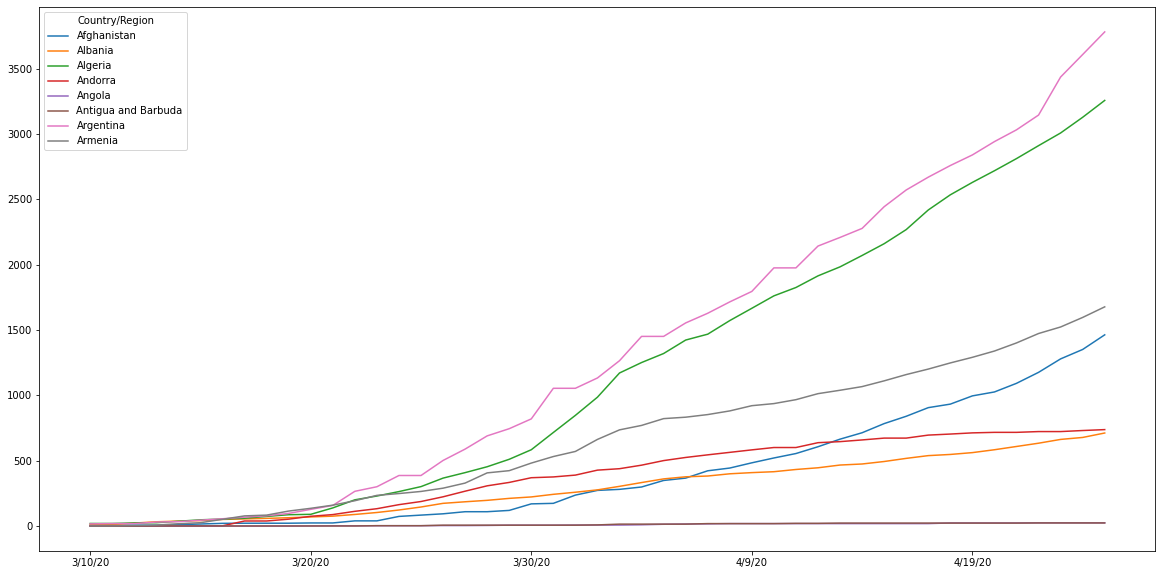

In [10]:
plt.rcParams['figure.figsize'] = [20, 10]
data.iloc[:8].T.iloc[50:].plot()

# Обрабатываем данные

## Представляем данные в виде, где каждой дате соответствует свой столбец

In [0]:
data2 = data.iloc[:,4:].stack().reset_index()
data2.columns = ["countries","date","confirmed"]

#Соединим смерти и заражения
data2 = data2.merge(data_deaths, how = 'left', left_on=('countries','date'), right_on=('countries','date'))

# Добавим выздоровивших
data2 = data2.merge(data_recovered, how = 'left', left_on=('countries','date'), right_on=('countries','date'))
data2 = data2[data2.countries.isin(countries.countries.to_list())]

#Объединим с сегодня
last_confirmed = data2.loc[pd.to_datetime(data2.date) == pd.to_datetime(today) - pd.offsets.Day(1)].sort_values(by='countries')
countries_today_new = countries_today[countries_today.confirmed.values > last_confirmed.confirmed.values]
data2 = pd.concat([data2, countries_today_new],ignore_index=True)

#Добавим Россию
data2 = pd.concat([data2, data_Ru],ignore_index=True)

#Добавим USA
data2 = pd.concat([data2, data_USA],ignore_index=True)

#Объединим с будущим
data_ans = data_ans[(data_ans.date != today)|(~(data_ans.countries.isin(countries_today_new.countries.values))&~(data_ans.countries.isin(data_Ru_today.countries.values)))]
data2 = pd.concat([data2, data_ans],ignore_index=True)


#Добавим информацию о стране(плотность, население и тд)
data2 = data2.merge(countries, how = 'right', left_on='countries', right_on='countries')

#Удалим дни без больных
data2 = data2[data2.confirmed != 0]
data2.loc[data2.confirmed == -1,"confirmed"] = 0
data2["date"] = pd.to_datetime(data2.date)


data2 = data2.merge(mobility_yandex, how = 'left', left_on=('iso_alpha3','date'), right_on=('country','date'))
mobility_min = mobility_yandex.groupby("country").min().drop(['date'], axis='columns')
mobility_min.columns = ['min_isolation']
data2 = data2.merge(mobility_min, how = 'left', left_on='iso_alpha3', right_on='country')
data2.loc[(data2.isolation.isnull())&(data2.date>pd.to_datetime("2020-04-01")),
          'isolation'] = data2.loc[(data2.isolation.isnull())&(data2.date>pd.to_datetime("2020-04-01")),'min_isolation'].to_numpy()
data2.drop(['country', 'min_isolation'], axis='columns',inplace=True)
#data2['isolation'] = data2['isolation'].fillna(data2['isolation'].mean())
data2['isolation'] = (data2['isolation'])/5


data2 = data2.merge(mobility_apple, how = 'left', left_on=('iso_alpha3','date'), right_on=('country','date'))
mobility_min = mobility_apple.groupby("country").min().drop(['date'], axis='columns')
mobility_min.columns = ['min_driving', 'min_walking']
data2 = data2.merge(mobility_min, how = 'left', left_on='iso_alpha3', right_on='country')
data2.loc[(data2.driving.isnull())&(data2.date>pd.to_datetime("2020-04-01")),
          ['driving', 'walking']] = data2.loc[(data2.driving.isnull())&(data2.date>pd.to_datetime("2020-04-01")),['min_driving', 'min_walking']].to_numpy()
data2.drop(['country', 'min_driving', 'min_walking'], axis='columns',inplace=True)
#data2.loc[data2.region==2,['driving', 'walking']] = data2.loc[data2.region==2,['driving', 'walking']].fillna(data2.loc[data2.iso_alpha3 == "USA",['driving', 'walking']].to_dict('records')[0])
#data2.loc[data2.region==1,['driving', 'walking']] = data2.loc[data2.region==1,['driving', 'walking']].fillna(data2.loc[data2.iso_alpha3 == "RUS",['driving', 'walking']].to_dict('records')[0])
#data2[['driving', 'walking']] = data2[['driving', 'walking']].fillna(data2[['driving', 'walking']].mean())
data2.loc[data2.region != 1,'isolation'] = (data2['driving'] +  data2['walking'])/100


data2 = data2.merge(mobility, how = 'left', left_on=('iso_alpha3','date'), right_on=('country','date'))
mobility_min = mobility.groupby("country").min().drop(['date'], axis='columns')
mobility_min.columns = ['min_Retail & recreation', 'min_Grocery & pharmacy', 'min_Parks',
       'min_Transit stations', 'min_Workplaces', 'min_Residential']
data2 = data2.merge(mobility_min, how = 'left', left_on='iso_alpha3', right_on='country')
data2.loc[(data2.Parks.isnull())&(data2.date>pd.to_datetime("2020-04-01")),
          ['Retail & recreation', 'Grocery & pharmacy', 'Parks', 'Transit stations', 'Workplaces', 
           'Residential']] = data2.loc[(data2.Parks.isnull())&(data2.date>pd.to_datetime("2020-04-01")),
                                       ['min_Retail & recreation', 'min_Grocery & pharmacy', 'min_Parks',
       'min_Transit stations', 'min_Workplaces', 'min_Residential']].to_numpy()
data2.drop(['country', 'min_Retail & recreation', 'min_Grocery & pharmacy', 'min_Parks',
       'min_Transit stations', 'min_Workplaces', 'min_Residential'], axis='columns',inplace=True)
"""data2[['Retail & recreation', 'Grocery & pharmacy', 'Parks',
       'Transit stations', 'Workplaces', 'Residential']] = data2[['Retail & recreation', 'Grocery & pharmacy', 'Parks',
       'Transit stations', 'Workplaces', 'Residential']].fillna(data2[['Retail & recreation', 'Grocery & pharmacy', 'Parks',
       'Transit stations', 'Workplaces', 'Residential']].mean())"""
data2.loc[data2.isolation.isnull(),'isolation'] = (data2['Retail & recreation'] +data2['Grocery & pharmacy'] +data2[ 'Parks'] 
                                                   +data2['Transit stations'] +data2[ 'Workplaces'] +data2[ 'Residential']+500)/1000     

data2['isolation'] = data2['isolation'].fillna(data2['isolation'].mean())

In [0]:
log_labels = True

if log_labels:
  data2.confirmed = np.log10(data2.confirmed+1)
  data2.deaths = np.log10(data2.deaths+1)
else:
  data2.confirmed = data2.confirmed
  data2.deaths = data2.deaths

## Добавить данные за прошлый день

In [0]:
old_con = data2["confirmed"].iloc[:-1]
old_con2 = data2["deaths"].iloc[:-1]
old_recovered = data2["recovered"].iloc[:-1]
data2 = data2.iloc[1:]
data2["pred_conf"] = old_con.values
data2["pred_deaths"] = old_con2.values
data2["pred_recovered"] = old_recovered.values

if log_labels:
  data2["delta_conf"] = data2["confirmed"] - data2["pred_conf"]
  data2["delta_deaths"] = data2["deaths"] - data2["pred_deaths"]
else:
  data2["delta_conf"] = data2["confirmed"] - data2["pred_conf"]
  data2["delta_deaths"] = data2["deaths"] - data2["pred_deaths"]  

data2 = data2.iloc[1:]
data2["delta_conf1"] = old_con.values[1:] - old_con.values[:-1]
data2["delta_deaths1"] = old_con2.values[1:] - old_con2.values[:-1]

data2 = data2.iloc[1:]
data2["delta_conf2"] = old_con.values[1:-1] - old_con.values[:-2]
data2["delta_deaths2"] = old_con2.values[1:-1] - old_con2.values[:-2]
data2["delta_delta_conf1"] = data2["delta_conf2"] - data2["delta_conf1"]
data2 = data2.iloc[1:]
data2["delta_conf3"] = old_con.values[1:-2] - old_con.values[:-3]
data2["delta_deaths3"] = old_con2.values[1:-2] - old_con2.values[:-3]
data2["delta_delta_conf2"] = data2["delta_conf3"] - data2["delta_conf2"]
data2 = data2.iloc[1:]
data2["delta_conf4"] = old_con.values[1:-3] - old_con.values[:-4]
data2["delta_deaths4"] = old_con2.values[1:-3] - old_con2.values[:-4]
data2["delta_delta_conf3"] = data2["delta_conf4"] - data2["delta_conf3"]
data2 = data2.iloc[1:]
data2["delta_conf5"] = old_con.values[1:-4] - old_con.values[:-5]
data2["delta_deaths5"] = old_con2.values[1:-4] - old_con2.values[:-5]
data2["delta_delta_conf4"] = data2["delta_conf5"] - data2["delta_conf4"]
data2 = data2.iloc[1:]
data2["delta_conf6"] = old_con.values[1:-5] - old_con.values[:-6]
data2["delta_deaths6"] = old_con2.values[1:-5] - old_con2.values[:-6]
data2["delta_delta_conf5"] = data2["delta_conf6"] - data2["delta_conf5"]
data2["delta_conf_sum"] = (data2["delta_conf1"] + data2["delta_conf2"] + data2["delta_conf3"] + data2["delta_conf4"] + data2["delta_conf5"] + data2["delta_conf6"]) /6
data2["delta_deaths_sum"] = (data2["delta_deaths1"] + data2["delta_deaths2"] + data2["delta_deaths3"] + data2["delta_deaths4"] + data2["delta_deaths5"] + data2["delta_deaths6"]) /6
data2["delta_delta_sum"] = (data2["delta_delta_conf1"] + data2["delta_delta_conf2"] + data2["delta_delta_conf3"] + data2["delta_delta_conf4"] + data2["delta_delta_conf5"]) /5
data2["delta_loss"] = 0
data2.loc[data2["delta_conf1"] < data2["delta_conf_sum"],"delta_loss"] = 1
          
delta_data = data2["confirmed"].iloc[1:]

data2 = data2.iloc[:-1]
data2["delta2"] =  delta_data.values - data2["confirmed"] + data2["delta_conf"]
data2 = data2.iloc[:-1]
data2["delta3"] =  delta_data.values[1:]  - data2["confirmed"] + data2["delta_conf"]
data2 = data2.iloc[:-1]
data2["delta4"] = delta_data.values[2:] - data2["confirmed"] + data2["delta_conf"]
data2 = data2.iloc[:-1]
data2["delta5"] =  delta_data.values[3:] - data2["confirmed"] + data2["delta_conf"]
data2 = data2.iloc[:-1]
data2["delta6"] =  delta_data.values[4:] - data2["confirmed"] + data2["delta_conf"]
data2 = data2.iloc[:-1]
data2["delta7"] =  delta_data.values[5:] - data2["confirmed"] + data2["delta_conf"]

data2["delta_conf_count"] = 0
data2.loc[(data2["delta_conf1"] < data2["delta_conf2"]) | ((data2["delta_conf1"] <0.02) & (data2["delta_conf1"]>0)),"delta_conf_count"] +=0.2
data2.loc[(data2["delta_conf2"] < data2["delta_conf3"]) | ((data2["delta_conf2"] <0.02) & (data2["delta_conf2"]>0)),"delta_conf_count"] +=0.2
data2.loc[(data2["delta_conf3"] < data2["delta_conf4"]) | ((data2["delta_conf3"] <0.02) & (data2["delta_conf3"]>0)),"delta_conf_count"] +=0.2
data2.loc[(data2["delta_conf4"] < data2["delta_conf5"]) | ((data2["delta_conf4"] <0.02) & (data2["delta_conf4"]>0)),"delta_conf_count"] +=0.2
data2.loc[(data2["delta_conf5"] < data2["delta_conf6"]) | ((data2["delta_conf5"] <0.02) & (data2["delta_conf5"]>0)),"delta_conf_count"] +=0.2

data2['population_log'] = np.log10(data2.population+1)
data2['pred_conf-population_log'] = data2['pred_conf'] - data2['population_log'] + 3

## Добавляем признак, количество дней от первого(пятого и тд) зараженного

In [0]:
# Считаем дни от первого больного
end_date = "2020-05-01"
#data2 = data2[(data2["date"]<pd.to_datetime("2020-05-1")) & ((data2["date"]>pd.to_datetime("2020-04-1")) | (data2.confirmed !=-1))]
data4 = data2[["countries","date"]].groupby("countries").min()
data4.columns = ["Date_min"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2["days"] = (data2.date - data2.Date_min).dt.days

data4 = data2.loc[data2.confirmed > 0.5, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_5"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_5'] = data2['Date_5'].fillna(pd.to_datetime(end_date))
data2["days_5"] = (data2.date - data2.Date_5).dt.days
#data2.loc[data2["days_5"]<0,"days_5"] = 0

data4 = data2.loc[data2.confirmed > 0.8, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_8"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_8'] = data2['Date_8'].fillna(pd.to_datetime(end_date))
data2["days_8"] = (data2.date - data2.Date_8).dt.days
#data2.loc[data2["days_10"]<0,"days_10"] = 0

data4 = data2.loc[data2.confirmed > 1, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_10"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_10'] = data2['Date_10'].fillna(pd.to_datetime(end_date))
data2["days_10"] = (data2.date - data2.Date_10).dt.days
#data2.loc[data2["days_10"]<0,"days_10"] = 0

data4 = data2.loc[data2.confirmed > 1.5, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_50"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_50'] = data2['Date_50'].fillna(pd.to_datetime(end_date))
data2["days_50"] = (data2.date - data2.Date_50).dt.days
#data2.loc[data2["days_50"]<0,"days_50"] = 0

data4 = data2.loc[data2.confirmed > 1.8, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_80"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_80'] = data2['Date_80'].fillna(pd.to_datetime(end_date))
data2["days_80"] = (data2.date - data2.Date_80).dt.days
#data2.loc[data2["days_10"]<0,"days_10"] = 0

data4 = data2.loc[data2.confirmed > 2, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_100"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_100'] = data2['Date_100'].fillna(pd.to_datetime(end_date))
data2["days_100"] = (data2.date - data2.Date_100).dt.days
#data2.loc[data2["days_100"]<0,"days_100"] = 0

data4 = data2.loc[data2.confirmed > 2.5, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_500"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_500'] = data2['Date_500'].fillna(pd.to_datetime(end_date))
data2["days_500"] = (data2.date - data2.Date_500).dt.days
#data2.loc[data2["days_500"]<0,"days_500"] = 0

data4 = data2.loc[data2.confirmed > 3, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_1000"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_1000'] = data2['Date_1000'].fillna(pd.to_datetime(end_date))
data2["days_1000"] = (data2.date - data2.Date_1000).dt.days
#data2.loc[data2["days_1000"]<0,"days_1000"] = 0

data2["days_mart"] = (data2.date - pd.to_datetime("2020-03-1")).dt.days
data2["days_after_Quarantine"] = (data2.date - pd.to_datetime(data2.Quarantine)).dt.days - 14
data2.loc[data2["days_after_Quarantine"]<0,"days_after_Quarantine"] = 0

data4 = data2.loc[data2['pred_conf-population_log'] > 0, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_1_1000"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_1_1000'] = data2['Date_1_1000'].fillna(pd.to_datetime(end_date))
data2["days_1_1000"] = (data2.date - data2["Date_1_1000"]).dt.days
data2.loc[data2["days_1_1000"]<0,"days_1_1000"] = 0

data4 = data2.loc[data2['pred_conf-population_log'] > -1, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_1_100"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_1_100'] = data2['Date_1_100'].fillna(pd.to_datetime(end_date))
data2["days_1_100"] = (data2.date - data2["Date_1_100"]).dt.days
#data2.loc[data2["days_1_100"]<0,"days_1_100"] = 0

data4 = data2.loc[data2['pred_conf-population_log'] > -2, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_1_10000"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_1_10000'] = data2['Date_1_10000'].fillna(pd.to_datetime(end_date))
data2["days_1_10000"] = (data2.date - data2["Date_1_10000"]).dt.days
#data2.loc[data2["days_1_10000"]<0,"days_1_10000"] = 0

data2.drop(['Date_min','Date_10','Date_100','Date_1000', 'Date_5','Date_50','Date_500', 'Date_1_1000', 'Date_1_100', 'Date_1_10000'], axis='columns',inplace=True)
data2.date = data2["date"].apply(lambda x: pd.Series(x.strftime("%m-%d")))


In [15]:
Scale = True

if Scale:
  data2.density = data2.density/data2.density.max()
  data2.fertility_rate = data2.fertility_rate/data2.fertility_rate.max()
  data2.land_area = np.log10(data2.land_area+1)
  data2.land_area = data2.land_area/data2.land_area.max()
  data2.median_age = data2.median_age/data2.median_age.max()
  data2.migrants = data2.migrants - data2.migrants.min()
  data2.migrants = np.log10(data2.migrants+1)
  data2.migrants = data2.migrants/data2.migrants.max()
  data2.population = data2.population/data2.population.max()
  data2.Health_GDP = data2.Health_GDP/data2.Health_GDP.max()
  data2.Health_USD = data2.Health_USD/data2.Health_USD.max()
  data2.Physicians = data2.Physicians/data2.Physicians.max()
  data2.tests = data2.tests/data2.tests.max()
  data2.testpop = data2.testpop/data2.testpop.max()
  data2.gatheringlimit = data2.gatheringlimit/data2.gatheringlimit.max()
  data2.hospibed = data2.hospibed/data2.hospibed.max()
  data2.healthperpop = data2.healthperpop/data2.healthperpop.max()
  data2.Nurse = data2.Nurse/data2.Nurse.max()
  data2["Age_old/new"] = data2["Age_old/new"]/data2["Age_old/new"].max()
  data2.Smoking = data2.Smoking/50
  data2.days = data2.days/100
  data2.days_10 = data2.days_10/100
  data2.days_100 = data2.days_100/100
  data2.days_1000 = data2.days_1000/100
  data2.days_5 = data2.days_5/100
  data2.days_50 = data2.days_50/100
  data2.days_500 = data2.days_500/100
  data2.days_8 = data2.days_8/100
  data2.days_80 = data2.days_80/100    
  data2.days_1_100 = data2.days_1_100/100  
  data2.days_1_1000 = data2.days_1_1000/100 
  data2.days_1_10000 = data2.days_1_10000/100 
  data2.days_mart = data2.days_mart/100

  data2.days_after_Quarantine = data2.days_after_Quarantine/100
  sc_days = 100
else:
  sc_days = 1
data2[data2.iso_alpha3 == "RUS"].iloc[70:75]

,countries,date,confirmed,deaths,recovered,iso_alpha3,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,Quarantine,Health_GDP,Health_USD,Physicians,Nurse,Age_old/new,Smoking,tests,testpop,gatheringlimit,hospibed,healthperpop,region,isolation,driving,walking,Parks,Residential,Retail & recreation,Transit stations,Workplaces,Grocery & pharmacy,pred_conf,pred_deaths,pred_recovered,delta_conf,...,delta_deaths3,delta_delta_conf2,delta_conf4,delta_deaths4,delta_delta_conf3,delta_conf5,delta_deaths5,delta_delta_conf4,delta_conf6,delta_deaths6,delta_delta_conf5,delta_conf_sum,delta_deaths_sum,delta_delta_sum,delta_loss,delta2,delta3,delta4,delta5,delta6,delta7,delta_conf_count,population_log,pred_conf-population_log,days,days_5,Date_8,days_8,days_10,days_50,Date_80,days_80,days_100,days_500,days_1000,days_mart,days_after_Quarantine,days_1_1000,days_1_100,days_1_10000
17978,Russia,04-10,4.076203,1.977724,2.900913,RUS,0.000342,0.257143,1.0,0.833333,0.9542,0.101391,0.74,0.0187,2020-03-30,0.309942,0.047529,0.487805,0.423645,0.391229,0.786,0.356813,0.003023,0.070348,0.288732,0.000089,0,1.1268,62.77,49.91,NaN,NaN,NaN,NaN,NaN,NaN,4.005695,1.886491,2.844477,0.070508,...,0.089611,0.009358,0.070774,0.018483,-0.001808,0.056544,0.019305,-0.014230,0.056997,0.099385,0.000453,0.064608,0.057070,-0.002106,0,0.127364,0.192164,0.257444,0.318649,0.383311,0.440516,0.4,8.164158,-1.158463,0.70,0.39,2020-03-06,0.35,0.35,0.28,2020-03-15,0.26,0.24,0.19,0.14,0.40,0.00,0.0,-0.03,0.11
17979,Russia,04-11,4.133060,2.029384,3.019532,RUS,0.000342,0.257143,1.0,0.833333,0.9542,0.101391,0.74,0.0187,2020-03-30,0.309942,0.047529,0.487805,0.423645,0.391229,0.786,0.356813,0.003023,0.070348,0.288732,0.000089,0,1.0030,55.68,44.62,NaN,NaN,NaN,NaN,NaN,NaN,4.076203,1.977724,2.900913,0.056856,...,0.035328,-0.004302,0.072582,0.089611,0.009358,0.070774,0.018483,-0.001808,0.056544,0.019305,-0.014230,0.066860,0.055712,-0.002793,0,0.121656,0.186935,0.248141,0.312803,0.370007,0.429069,0.2,8.164158,-1.087954,0.71,0.40,2020-03-06,0.36,0.36,0.29,2020-03-15,0.27,0.25,0.20,0.15,0.41,0.00,0.0,-0.02,0.12
17980,Russia,04-12,4.197859,2.117271,3.111263,RUS,0.000342,0.257143,1.0,0.833333,0.9542,0.101391,0.74,0.0187,2020-03-30,0.309942,0.047529,0.487805,0.423645,0.391229,0.786,0.356813,0.003023,0.070348,0.288732,0.000089,0,0.9898,55.92,43.06,NaN,NaN,NaN,NaN,NaN,NaN,4.133060,2.029384,3.019532,0.064800,...,0.080311,-0.002982,0.063224,0.035328,-0.004302,0.072582,0.089611,0.009358,0.070774,0.018483,-0.001808,0.066912,0.061104,0.002784,1,0.130079,0.191285,0.255947,0.313151,0.372212,0.432717,0.4,8.164158,-1.031098,0.72,0.41,2020-03-06,0.37,0.37,0.30,2020-03-15,0.28,0.26,0.21,0.16,0.42,0.00,0.0,-0.01,0.13
17981,Russia,04-13,4.263139,2.173186,3.167613,RUS,0.000342,0.257143,1.0,0.833333,0.9542,0.101391,0.74,0.0187,2020-03-30,0.309942,0.047529,0.487805,0.423645,0.391229,0.786,0.356813,0.003023,0.070348,0.288732,0.000089,0,1.0975,59.94,49.81,NaN,NaN,NaN,NaN,NaN,NaN,4.197859,2.117271,3.111263,0.065280,...,0.091233,0.013652,0.067526,0.080311,-0.002982,0.063224,0.035328,-0.004302,0.072582,0.089611,0.009358,0.065916,0.072672,0.001557,1,0.126485,0.191147,0.248352,0.307413,0.367918,0.434132,0.4,8.164158,-0.966299,0.73,0.42,2020-03-06,0.38,0.38,0.31,2020-03-15,0.29,0.27,0.22,0.17,0.43,0.00,0.0,0.00,0.14
17982,Russia,04-14,4.324344,2.232996,3.229170,RUS,0.000342,0.257143,1.0,0.833333,0.9542,0.101391,0.74,0.0187,2020-03-30,0.309942,0.047529,0.487805,0.423645,0.391229,0.786,0.356813,0.003023,0.070348,0.288732,0.000089,0,1.0840,61.43,46.97,NaN,NaN,NaN,NaN,NaN,NaN,4.263139,2.173186,3.167613,0.061205,...,0.051660,-0.007943,0.070508,0.091233,0.013652,0.067526,0.080311,-0.002982,0.063224,0.035328,-0.004302,0.064699,0.067056,-0.000411,0,0.125868,0.183072,0.242133,0.302638,0.368853,0.410085,0.2,8.164158,-0.901019,0.74,0.43,2020-03-06,0.39,0.39,0.32,2020-03-15,0.30,0.28,0.23,0.18,0.44,0.01,0.0,0.01,0.15


In [0]:
def prog_delta_log(model):
  prediction_confirmed = model.predict(new_data_list)
  if log_labels:
    prediction_confirmed = prediction_confirmed  + new_data_list.pred_conf.values
    prediction_confirmed = 10**prediction_confirmed - 1
  else:
    prediction_confirmed = prediction_confirmed + np.log10(abs(new_data_list.delta_conf1.values)+1)
    prediction_confirmed = 10**prediction_confirmed - 1 + new_data_list.pred_conf.values
    prediction_confirmed = prediction_confirmed 
  return prediction_confirmed
def plot_new(list_countries, Matrix, subplot_x = 2, days_before = 10, point = True):
  dat2 = data2.copy()
  plt.rcParams['figure.figsize'] = [20, len(list_countries)*20/subplot_x**2]
  if log_labels:
    dat2.confirmed = 10**dat2.confirmed - 1
  else:
    dat2.confirmed = dat2.confirmed
  for i, Country in enumerate(list_countries):
    plt.subplot(len(list_countries)// subplot_x + 1, subplot_x, i+1)
    yyy = dat2.loc[(dat2.iso_alpha3 == Country)&(dat2.confirmed>0)&(dat2.days_mart>=(days_x - days_before)/sc_days)]

    if point:
      plt.plot(yyy.date, yyy.confirmed, label = "Истинное значение", marker='o')
      ax = plt.gca()
      for x,y,i in zip(yyy.date,yyy.confirmed,range(0,len(yyy))):
        if not i % ((subplot_x * (days_before+days_prog))//20):
          plt.annotate(int(y), (x,y), textcoords="offset points", xytext=(-5,10), ha="right", va = "bottom")
    else:
      plt.plot(yyy.date, yyy.confirmed, label = "Истинное значение")
    plt.gca().set(xlabel='Дата', ylabel='Заражения')
    yyy2 = Matrix.loc[:,[Country]]
    if point:
      plt.plot(yyy2, label = "name", marker='o')
      ax = plt.gca()
      for x,y,i in zip(yyy2.index,yyy2.values.T[0],range(0,len(yyy2))):
        if not i % ((subplot_x * (days_before+days_prog))//20):
          plt.annotate(int(y), (x,y), textcoords="offset points", xytext=(5,-10), ha="left", va = "top")
    else:
      plt.plot(yyy2, label = "name")
    plt.title(dic_countries[Country])
    plt.xticks(np.arange(0, (days_before+days_prog), ((days_before+days_prog)//10)*subplot_x))
    plt.grid(True)
    plt.legend()  
def pred_score(predictions, day):
  yyy = new_data[(new_data.days_mart==(days_x + day - 1)/sc_days) & (new_data.confirmed > 0)]
  region_list_x = new_data[(new_data.days_mart==(days_x)/sc_days) & (new_data.confirmed > 0)].countries.to_list()
  yyy = yyy[yyy.countries.isin(region_list_x)]
  if len(yyy)==len(predictions):
    if log_labels:
      labels = 10**yyy.confirmed.values  - 1
    else:
      labels = yyy.confirmed.values
    return np.mean(np.abs(np.log10((predictions+1)/(labels+1))))
  else:
    return 0         

# Отделяем данные на трейн и тест

In [32]:
#Выберите день начала приватных данных начиная с 1 марта
days_x = 50 #57 
iterat = 1000
days_prog = 8

#type_ans_delta - Предсказывать общее число, или изменение за день
type_ans_delta = True

#ВЫберите данные(только регионы России, только страны, всё)
type_reg = "all"
#type_reg = "country"
#type_reg = "region"
#type_reg = "no_USA"

param_list =['countries', 'confirmed', 'deaths', 'iso_alpha3', 'delta_conf', 'delta_deaths', 'region',
              'pred_conf', 'pred_deaths', 'delta_conf1', 'delta_deaths1',
             'delta2',  'delta3',  'delta4',  'delta5',  'delta6',  'delta7', 
              'delta_conf_count',
             'delta_deaths2','delta_deaths3','delta_deaths4','delta_deaths5','delta_deaths6',
             "isolation",
             'urban_pop_rate',             
              'pred_conf-population_log',              
             'population_log',
             'land_area',
             'days',
             'days_10',
             'days_100',
#             'days_1000',
             'days_5',
             'days_50',
             'days_500',
             'days_8',
             'days_80',                        
             'days_1_100', 
             'days_1_1000',              
             'days_1_10000',
             
             'delta_loss',  
             'delta_delta_conf1',
             'delta_delta_conf2',
             'delta_delta_conf3',
             'delta_delta_conf4',
             'delta_delta_conf5',
#             "delta_conf_sum",
#             "delta_deaths_sum",
#             'delta_delta_sum',

             'delta_conf2', 
             'delta_conf3', 
             'delta_conf4', 
             'delta_conf5', 
             'delta_conf6', 

             'days_mart']

data3 = data2[param_list]


if type_reg == "region":
  data3 = data3[data3['region'] == 1]
elif  type_reg == "country":
  data3 = data3[data3['region'] == 0]
elif  type_reg == "no_USA":
  data3 = data3[(data3['region'] == 0)|(data3['region'] == 1)]  
else:
  data3 = data3

model_Confirmed, model_Death = {}, {}

#Приватные данные
type_reg_mean = "no_USA"

new_data = data3[data3.days_mart >= (days_x)/sc_days]
if type_reg_mean == "region":
  new_data = new_data[new_data['region'] == 1]
elif  type_reg_mean == "country":
  new_data = new_data[new_data['region'] == 0]
elif  type_reg_mean == "no_USA":
  new_data = new_data[(new_data['region'] == 0)|(new_data['region'] == 1)]  

data_x = new_data[new_data.days_mart == (days_x)/sc_days]
old_data = data3[(data3.days_mart <= (days_x-5)/sc_days) & (data3.confirmed > 0)]

if log_labels:
  train_labels = old_data.delta_conf
  delta2 = old_data.delta2
  delta3 = old_data.delta3
  delta4 = old_data.delta4
  delta5 = old_data.delta5
  delta6 = old_data.delta6
  delta7 = old_data.delta7
else:  
  train_labels = - np.log10(abs(old_data.delta_conf1)+1) + np.log10(abs(old_data.delta_conf)+1)
  delta2 = - np.log10(abs(old_data.delta_conf1)+1) + np.log10(abs(old_data.delta2)+1)
  delta3 = - np.log10(abs(old_data.delta_conf1)+1) + np.log10(abs(old_data.delta3)+1)
  delta4 = - np.log10(abs(old_data.delta_conf1)+1) + np.log10(abs(old_data.delta4)+1)
  delta5 = - np.log10(abs(old_data.delta_conf1)+1) + np.log10(abs(old_data.delta5)+1)
  delta6 = - np.log10(abs(old_data.delta_conf1)+1) + np.log10(abs(old_data.delta6)+1)
  delta7 = - np.log10(abs(old_data.delta_conf1)+1) + np.log10(abs(old_data.delta7)+1)

#Убираем ответ из данных
train_data = old_data.drop(['delta2',  'delta3',  'delta4',  'delta5',  'delta6',  'delta7', 'iso_alpha3','region','confirmed','countries','deaths',"delta_conf","delta_deaths"], axis='columns')
new_data_list = data_x.drop(['delta2',  'delta3',  'delta4',  'delta5',  'delta6',  'delta7','iso_alpha3','region','confirmed','countries','deaths',"delta_conf","delta_deaths"], axis='columns')  
old_data

,countries,confirmed,deaths,iso_alpha3,delta_conf,delta_deaths,region,pred_conf,pred_deaths,delta_conf1,delta_deaths1,delta2,delta3,delta4,delta5,delta6,delta7,delta_conf_count,delta_deaths2,delta_deaths3,delta_deaths4,delta_deaths5,delta_deaths6,isolation,urban_pop_rate,pred_conf-population_log,population_log,land_area,days,days_10,days_100,days_5,days_50,days_500,days_8,days_80,days_1_100,days_1_1000,days_1_10000,delta_loss,delta_delta_conf1,delta_delta_conf2,delta_delta_conf3,delta_delta_conf4,delta_delta_conf5,delta_conf2,delta_conf3,delta_conf4,delta_conf5,delta_conf6,days_mart
0,Afghanistan,0.301030,0.00000,AFG,0.000000,0.00000,0,0.301030,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.397940,0.0,0.00000,0.0,0.0,0.0,0.0,0.529000,0.250,-4.289236,7.590266,0.806021,0.00,-0.12,-0.25,-0.06,-0.20,-0.34,-0.09,-0.22,-0.60,0.0,-0.37,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01
1,Afghanistan,0.301030,0.00000,AFG,0.000000,0.00000,0,0.301030,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.397940,0.397940,0.0,0.00000,0.0,0.0,0.0,0.0,0.517000,0.250,-4.289236,7.590266,0.806021,0.01,-0.11,-0.24,-0.05,-0.19,-0.33,-0.08,-0.21,-0.59,0.0,-0.36,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02
2,Afghanistan,0.301030,0.00000,AFG,0.000000,0.00000,0,0.301030,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.397940,0.397940,0.477121,0.0,0.00000,0.0,0.0,0.0,0.0,0.520000,0.250,-4.289236,7.590266,0.806021,0.02,-0.10,-0.23,-0.04,-0.18,-0.32,-0.07,-0.20,-0.58,0.0,-0.35,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.03
3,Afghanistan,0.301030,0.00000,AFG,0.000000,0.00000,0,0.301030,0.00000,0.000000,0.00000,0.000000,0.000000,0.397940,0.397940,0.477121,0.602060,0.0,0.00000,0.0,0.0,0.0,0.0,0.531000,0.250,-4.289236,7.590266,0.806021,0.03,-0.09,-0.22,-0.03,-0.17,-0.31,-0.06,-0.19,-0.57,0.0,-0.34,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04
4,Afghanistan,0.301030,0.00000,AFG,0.000000,0.00000,0,0.301030,0.00000,0.000000,0.00000,0.000000,0.397940,0.397940,0.477121,0.602060,0.602060,0.0,0.00000,0.0,0.0,0.0,0.0,0.527000,0.250,-4.289236,7.590266,0.806021,0.04,-0.08,-0.21,-0.02,-0.16,-0.30,-0.05,-0.18,-0.56,0.0,-0.33,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40967,Wyoming,2.418301,0.00000,USA_Wyoming,0.038090,0.00000,2,2.380211,0.00000,0.016599,0.00000,0.052758,0.060698,0.071575,0.079181,0.092545,0.105510,0.8,0.00000,0.0,0.0,0.0,0.0,0.433431,0.648,-0.374259,5.754470,0.749036,0.30,0.25,0.11,0.25,0.17,-0.09,0.25,0.15,0.14,0.0,0.24,1,0.000660,-0.007366,0.002284,0.015440,-0.005110,0.017259,0.009893,0.012177,0.027617,0.022507,0.41
40968,Wyoming,2.432969,0.00000,USA_Wyoming,0.014668,0.00000,2,2.418301,0.00000,0.038090,0.00000,0.022608,0.033485,0.041091,0.054455,0.067420,0.073060,0.8,0.00000,0.0,0.0,0.0,0.0,0.433431,0.648,-0.336169,5.754470,0.749036,0.31,0.26,0.12,0.26,0.18,-0.08,0.26,0.16,0.15,0.0,0.25,0,-0.021491,0.000660,-0.007366,0.002284,0.015440,0.016599,0.017259,0.009893,0.012177,0.027617,0.42
40969,Wyoming,2.440909,0.30103,USA_Wyoming,0.007940,0.30103,2,2.432969,0.00000,0.014668,0.00000,0.018817,0.026423,0.039787,0.052752,0.058392,0.063960,0.8,0.00000,0.0,0.0,0.0,0.0,0.433431,0.648,-0.321501,5.754470,0.749036,0.32,0.27,0.13,0.27,0.19,-0.07,0.27,0.17,0.16,0.0,0.26,1,0.023422,-0.021491,0.000660,-0.007366,0.002284,0.038090,0.016599,0.017259,0.009893,0.012177,0.43
40970,Wyoming,2.451786,0.30103,USA_Wyoming,0.010877,0.00000,2,2.440909,0.30103,0.007940,0.30103,0.018483,0.031847,0.044812,0.050453,0.056021,0.061518,0.8,0.00000,0.0,0.0,0.0,0.0,0.433431,0.648,-0.313561,5.754470,

# Модели

### Обучаем xgboost

In [33]:
"""model_Confirmed["Xgboost"] = []
model_Confirmed["Xgboost"].append(xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=iterat, max_depth=30, 
                                              n_jobs = -1).fit(train_data, train_labels))

model_Confirmed["Xgboost"].append(xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=iterat, max_depth=30, 
                                              n_jobs = -1).fit(train_data[delta2 >= 0], delta2[delta2 >= 0]))
model_Confirmed["Xgboost"].append(xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=iterat, max_depth=30, 
                                              n_jobs = -1).fit(train_data[delta3 >= 0], delta3[delta3 >= 0]))
model_Confirmed["Xgboost"].append(xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=iterat, max_depth=30, 
                                              n_jobs = -1).fit(train_data[delta4 >= 0], delta4[delta4 >= 0]))
model_Confirmed["Xgboost"].append(xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=iterat, max_depth=30, 
                                              n_jobs = -1).fit(train_data[delta5 >= 0], delta5[delta5 >= 0]))
model_Confirmed["Xgboost"].append(xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=iterat, max_depth=30, 
                                              n_jobs = -1).fit(train_data[delta6 >= 0], delta6[delta6 >= 0]))
model_Confirmed["Xgboost"].append(xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=iterat, max_depth=30, 
                                              n_jobs = -1).fit(train_data[delta7 >= 0], delta7[delta7 >= 0]))"""

'model_Confirmed["Xgboost"] = []\nmodel_Confirmed["Xgboost"].append(xgb.XGBRegressor(objective =\'reg:squarederror\',n_estimators=iterat, max_depth=30, \n                                              n_jobs = -1).fit(train_data, train_labels))\n\nmodel_Confirmed["Xgboost"].append(xgb.XGBRegressor(objective =\'reg:squarederror\',n_estimators=iterat, max_depth=30, \n                                              n_jobs = -1).fit(train_data[delta2 >= 0], delta2[delta2 >= 0]))\nmodel_Confirmed["Xgboost"].append(xgb.XGBRegressor(objective =\'reg:squarederror\',n_estimators=iterat, max_depth=30, \n                                              n_jobs = -1).fit(train_data[delta3 >= 0], delta3[delta3 >= 0]))\nmodel_Confirmed["Xgboost"].append(xgb.XGBRegressor(objective =\'reg:squarederror\',n_estimators=iterat, max_depth=30, \n                                              n_jobs = -1).fit(train_data[delta4 >= 0], delta4[delta4 >= 0]))\nmodel_Confirmed["Xgboost"].append(xgb.XGBRegressor(objective

### Обучаем Adaboost Regressor

In [0]:
treeDepth = 30
mdl = tree.DecisionTreeRegressor(max_depth=treeDepth)
param_grid = {
    'n_estimators': [iterat//10],
    'learning_rate': [0.0001],
    'loss' : ["exponential"]}
regrMdl = ensemble.AdaBoostRegressor(base_estimator=mdl)

model_Confirmed["Adaboost"] = []
model_Confirmed["Adaboost"].append(model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, 
                                         cv = 2, n_jobs = -1).fit(train_data,train_labels))
model_Confirmed["Adaboost"].append(model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, 
                                         cv = 2, n_jobs = -1).fit(train_data[delta2 >= 0], delta2[delta2 >= 0]))
model_Confirmed["Adaboost"].append(model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, 
                                         cv = 2, n_jobs = -1).fit(train_data[delta3 >= 0], delta3[delta3 >= 0]))
model_Confirmed["Adaboost"].append(model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, 
                                         cv = 2, n_jobs = -1).fit(train_data[delta4 >= 0], delta4[delta4 >= 0]))
model_Confirmed["Adaboost"].append(model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, 
                                         cv = 2, n_jobs = -1).fit(train_data[delta5 >= 0], delta5[delta5 >= 0]))
model_Confirmed["Adaboost"].append(model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, 
                                         cv = 2, n_jobs = -1).fit(train_data[delta6 >= 0], delta6[delta6 >= 0]))
model_Confirmed["Adaboost"].append(model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, 
                                         cv = 2, n_jobs = -1).fit(train_data[delta7 >= 0], delta7[delta7 >= 0]))

### Catboost

In [0]:
#iterat больше лучше
model_Confirmed["catboost"] = []
model_Confirmed["catboost"].append(CatBoostRegressor(iterations=iterat, depth=12,  l2_leaf_reg = 1, verbose=False).fit(train_data,train_labels))
model_Confirmed["catboost"].append(CatBoostRegressor(iterations=iterat, depth=12,  l2_leaf_reg = 1, verbose=False).fit(train_data[delta2 >= 0], delta2[delta2 >= 0]))
model_Confirmed["catboost"].append(CatBoostRegressor(iterations=iterat, depth=12,  l2_leaf_reg = 1, verbose=False).fit(train_data[delta3 >= 0], delta3[delta3 >= 0]))
model_Confirmed["catboost"].append(CatBoostRegressor(iterations=iterat, depth=12,  l2_leaf_reg = 1, verbose=False).fit(train_data[delta4 >= 0], delta4[delta4 >= 0]))
model_Confirmed["catboost"].append(CatBoostRegressor(iterations=iterat, depth=12,  l2_leaf_reg = 1, verbose=False).fit(train_data[delta5 >= 0], delta5[delta5 >= 0]))
model_Confirmed["catboost"].append(CatBoostRegressor(iterations=iterat, depth=12,  l2_leaf_reg = 1, verbose=False).fit(train_data[delta6 >= 0], delta6[delta6 >= 0]))
model_Confirmed["catboost"].append(CatBoostRegressor(iterations=iterat, depth=12,  l2_leaf_reg = 1, verbose=False).fit(train_data[delta7 >= 0], delta7[delta7 >= 0]))

### Lightgbm

In [0]:
params = {} 
model_Confirmed["lightgbm"] = []
d_train = lgb.Dataset(train_data, label=train_labels)
model_Confirmed["lightgbm"].append(lgb.train(params, d_train, iterat))
d_train = lgb.Dataset(train_data[delta2 >= 0], delta2[delta2 >= 0])
model_Confirmed["lightgbm"].append(lgb.train(params, d_train, iterat))
d_train = lgb.Dataset(train_data[delta3 >= 0], delta3[delta3 >= 0])
model_Confirmed["lightgbm"].append(lgb.train(params, d_train, iterat))
d_train = lgb.Dataset(train_data[delta4 >= 0], delta4[delta4 >= 0])
model_Confirmed["lightgbm"].append(lgb.train(params, d_train, iterat))
d_train = lgb.Dataset(train_data[delta5 >= 0], delta5[delta5 >= 0])
model_Confirmed["lightgbm"].append(lgb.train(params, d_train, iterat))
d_train = lgb.Dataset(train_data[delta6 >= 0], delta6[delta6 >= 0])
model_Confirmed["lightgbm"].append(lgb.train(params, d_train, iterat))
d_train = lgb.Dataset(train_data[delta7 >= 0], delta7[delta7 >= 0])
model_Confirmed["lightgbm"].append(lgb.train(params, d_train, iterat))

## Обучаем свою модель

In [0]:
#model_Confirmed["new"] = 
#model_Death["new"] = 

#Предсказываем новые данные

## Функция отображения данных

## Расчёт значений

Adaboost 0.24727510386696977 [0.018774241432098965, 0.02760575810271814, 0.03527155531592316, 0.048875706615581355, 0.05419289051903117, 0.06255495188161696]
catboost 0.24863830658766034 [0.019337507562303787, 0.02856364583691804, 0.035203045542451156, 0.047607075754959975, 0.054037168735971836, 0.06388986315505553]
lightgbm 0.28231752224234485 [0.01995057632132921, 0.03112380371615294, 0.04191582322696294, 0.05533443967046048, 0.05968074431851716, 0.07431213498892214]
Среднее 0.2500044163710721 [0.01883969116362326, 0.0279646055037186, 0.035895798281485175, 0.04887593662392209, 0.053810001541439126, 0.06461838325688392]


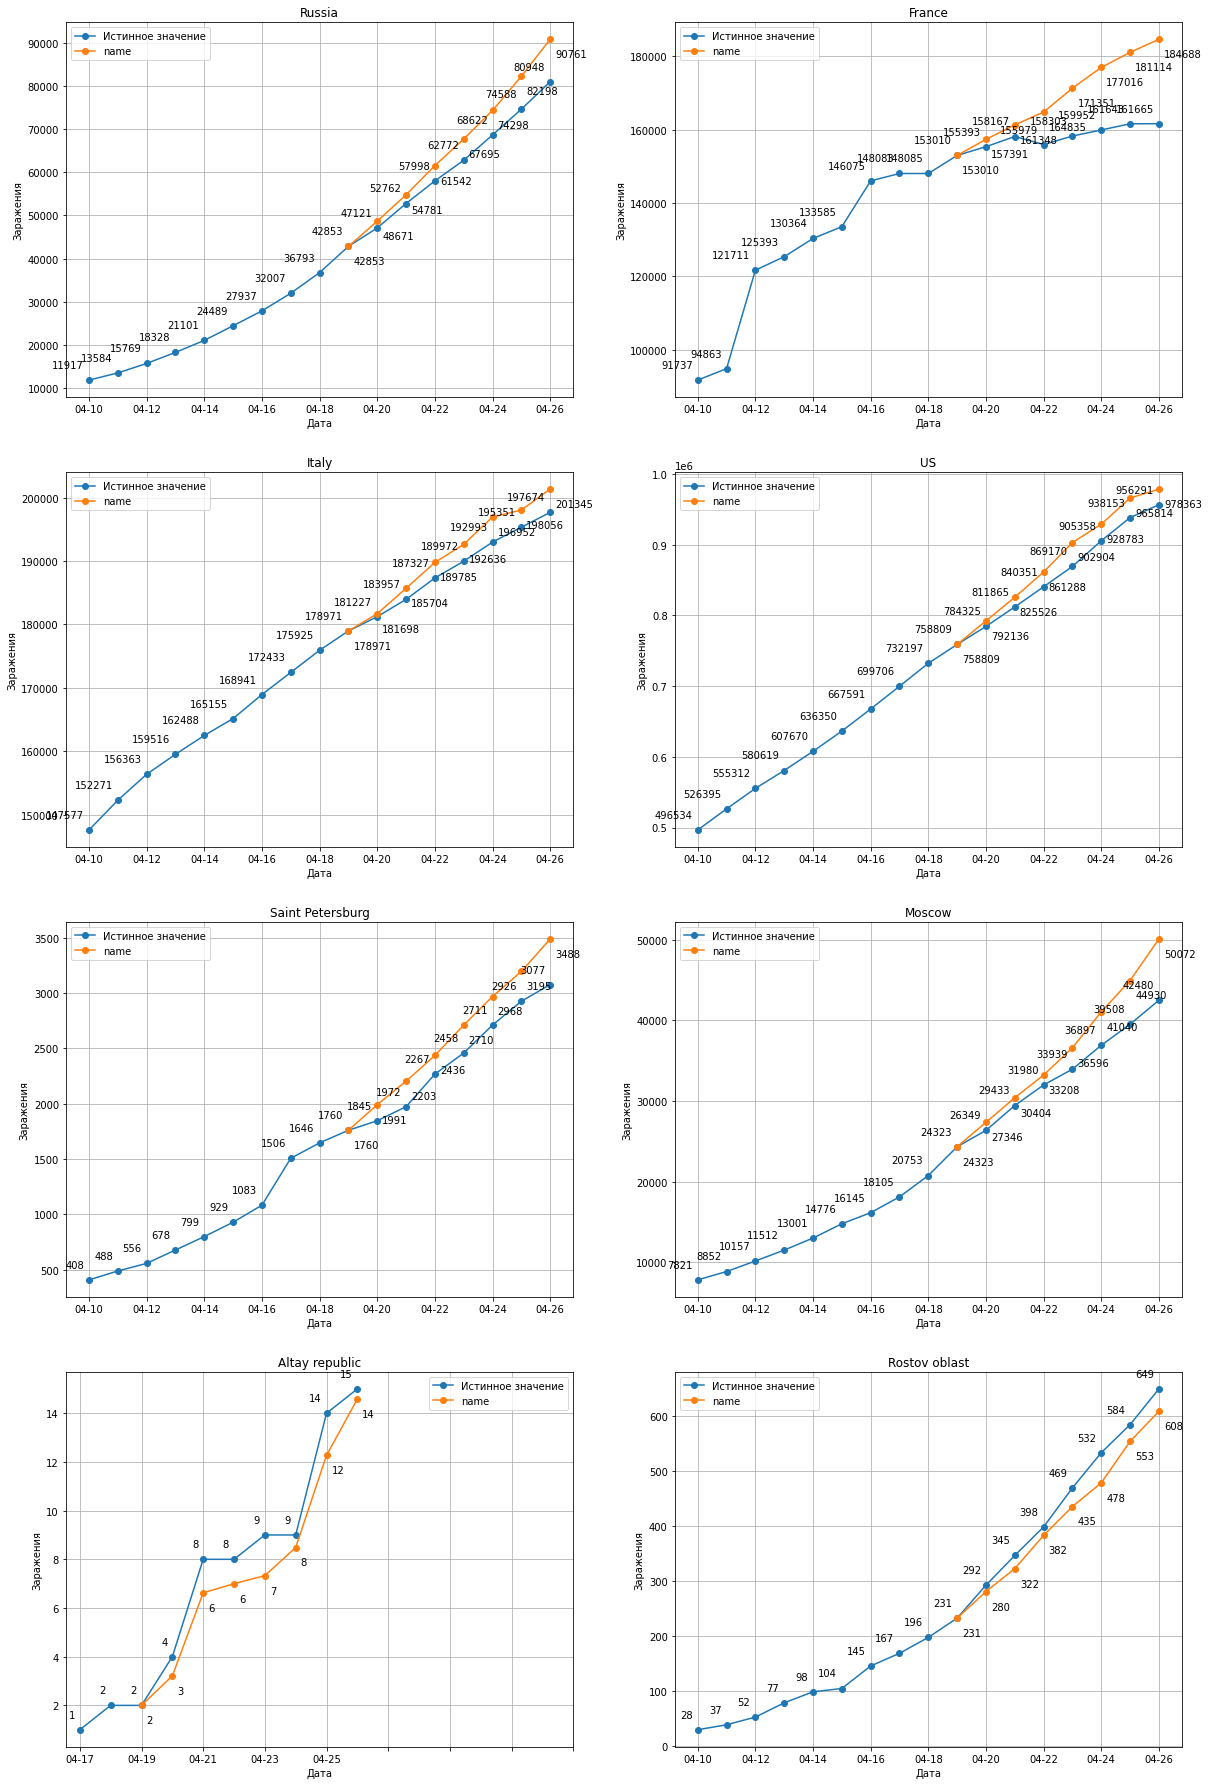

In [42]:
predictions_mean = np.zeros((8,len(new_data_list)))
for model in model_Confirmed:
  if log_labels:
    predictions = [10**new_data_list.pred_conf.values-1]
  else:
    predictions = [new_data_list.pred_conf.values]
  for mod in model_Confirmed[model]:
    pred = prog_delta_log(mod)
    pred[pred < predictions[len(predictions)-1]] = predictions[len(predictions)-1][pred < predictions[len(predictions)-1]] 
    predictions.append(pred)
  predictions_mean += np.array(predictions)
  scores = []
  for i,pred in enumerate(predictions):
      score = pred_score(pred,i)
      if score:
        scores.append(score)
  print(model, np.sum(scores), scores)      

predictions_mean = predictions_mean/len(model_Confirmed)
scores = []
for i,pred in enumerate(predictions_mean):
    score = pred_score(pred,i)
    if score:
      scores.append(score)
print("Среднее", np.sum(scores), scores)

labels = data_x.iso_alpha3
data_list = pd.date_range('2020-04-'+str(days_x-31), periods = 7+1, freq ='d')
data_list = data_list.strftime('%#m-%#d') 
Matrix = pd.DataFrame(predictions_mean,columns = labels,index = data_list)



# Создаём список стран
#list_countries = countries.iso_alpha3.to_list()[-100:-90]
list_countries = []
list_countries.extend(["RUS","FRA","ITA","USA"])
list_countries.extend(["RU-SPE","RU-MOW","RU-AL","RU-ROS"])
# Количество графиков в строке
subplot_x = 2

# Отмечать точки
point = True

#За сколько дней до начала прогноза
days_before = 10

plot_new(list_countries, Matrix, subplot_x, days_before, point)

# Сохраняем прогноз

In [0]:
ans = Matrix.stack().reset_index()
ans_Death = Matrix.stack().reset_index()
ans["prediction_deaths"] = ans_Death[0]
ans.columns = ['date','region','prediction_confirmed', 'prediction_deaths']
ans['date'] = pd.to_datetime('2020-'+ans['date'])
ans['prediction_confirmed'] = ans['prediction_confirmed'].astype('int')
ans['prediction_deaths'] = ans['prediction_deaths'].astype('int')
ans.sort_values(by=['region', 'date']).to_csv('submission.csv', index=False)